# COVID-19 cases in hospital and ICU by Ontario Health (OH) region

This dataset comes from [Ontario Data Catalogue](https://data.ontario.ca/en/dataset/covid-19-cases-in-hospital-and-icu-by-ontario-health-region) and it compiles daily snapshots of publicly reported data on 2019 Novel Coronavirus (COVID-19) testing in Ontario.

In [1]:
# Set up modules.
import pandas as pd
import numpy as np
import datetime as dt
import scipy.stats as stats

from matplotlib import pyplot as plt, cm
from custom_functions import set_timeline

In [2]:
# Import the csv file using `date` as index.
df_region_icu = pd.read_csv('../data/region_hospital_icu_covid_data.csv', index_col ='date')

# Convert the indices to pandas datetime objects.
df_region_icu.index = pd.to_datetime(df_region_icu.index)

In [3]:
# Drop the rows with dates earlier than the first entry in `icu_beds.csv`, which is 2020-05-01.
df_region_icu.drop(df_region_icu.loc[df_region_icu.index < '2020-05-01'].index, inplace=True)
df_region_icu.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5035 entries, 2020-05-01 to 2023-02-02
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   oh_region                 5035 non-null   object
 1   icu_current_covid         5035 non-null   int64 
 2   icu_current_covid_vented  5035 non-null   int64 
 3   hospitalizations          5035 non-null   int64 
 4   icu_crci_total            5035 non-null   int64 
 5   icu_crci_total_vented     5035 non-null   int64 
 6   icu_former_covid          5035 non-null   int64 
 7   icu_former_covid_vented   5035 non-null   int64 
dtypes: int64(7), object(1)
memory usage: 354.0+ KB


In [4]:
# Print missing record for each region.
dates = pd.date_range(start = '2020-05-01', end = '2023-02-02' )
regions = ['NORTH', 'CENTRAL', 'EAST', 'WEST', 'TORONTO']
for region in regions:
    diff_dates = dates.difference(df_region_icu[df_region_icu['oh_region']==region].index).date
    for date in diff_dates:
        print(f'{region} is missing the record on {date}.')

NORTH is missing the record on 2020-07-04.
CENTRAL is missing the record on 2020-07-04.
EAST is missing the record on 2020-07-04.
WEST is missing the record on 2020-07-04.
TORONTO is missing the record on 2020-07-04.


In [5]:
# Create a list of row indices corresponding to first yearly entries for setting the major x-axis ticks in time series plots.
index_1st_yearly_entry = df_region_icu[~df_region_icu.index.year.duplicated()].index

# Set up a dictionary that contains regional population (Ontario Health Region).
pops = [789299, 5000000, 3700000, 4000000, 1400000]
region_pops = dict(zip(regions, pops))

# Replace number of CRCI patients in ICUs by number of CRCI patients per 100,000 regional population.
df_region_icu['icu_crci_total'] = df_region_icu.groupby('oh_region')['icu_crci_total'].transform(lambda x:x*100000/region_pops[x.name])

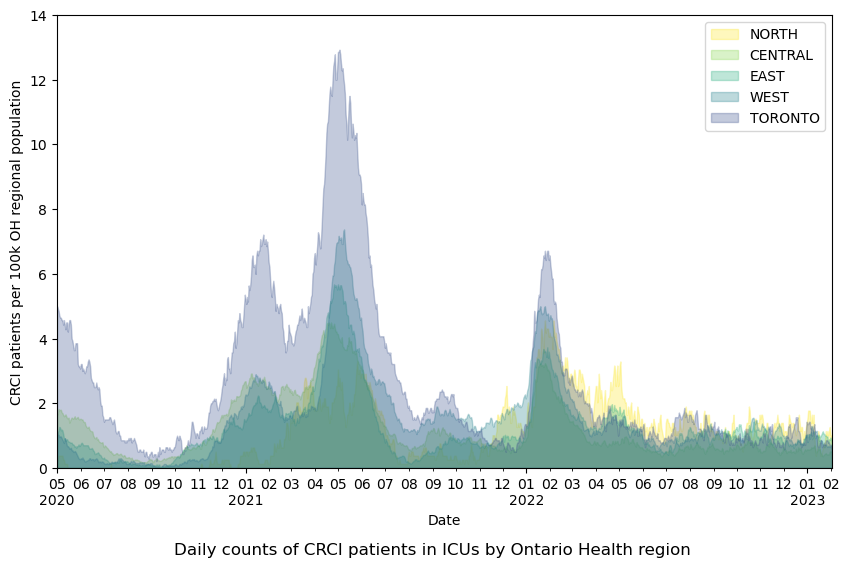

In [8]:
# Set global figure dpi.
plt.rcParams["figure.dpi"] = 100

fig, ax = plt.subplots(figsize=(10, 6))
color = cm.viridis(np.linspace(1, 0.25, len(regions)))
for i, region in enumerate(regions):
    ax.fill_between(df_region_icu.loc[df_region_icu.oh_region == region].index, 0,
                    df_region_icu.loc[df_region_icu.oh_region == region].icu_crci_total, label=region, alpha=0.3, color=color[i])
#     ax.plot(df_region_icu.loc[df_region_icu.oh_region == region].icu_crci_total, label=region, c=color[i])
ax.legend()
ax.set(xlabel='Date', xlim=(dates[0], dates[-1]), xticks=index_1st_yearly_entry,
       ylabel='CRCI patients per 100k OH regional population', ylim=(0, 14))
set_timeline(ax)

fig.suptitle('Daily counts of CRCI patients in ICUs by Ontario Health region', y=0)
fig.savefig('../output/crci_patients_by_oh_region.png', bbox_inches='tight')

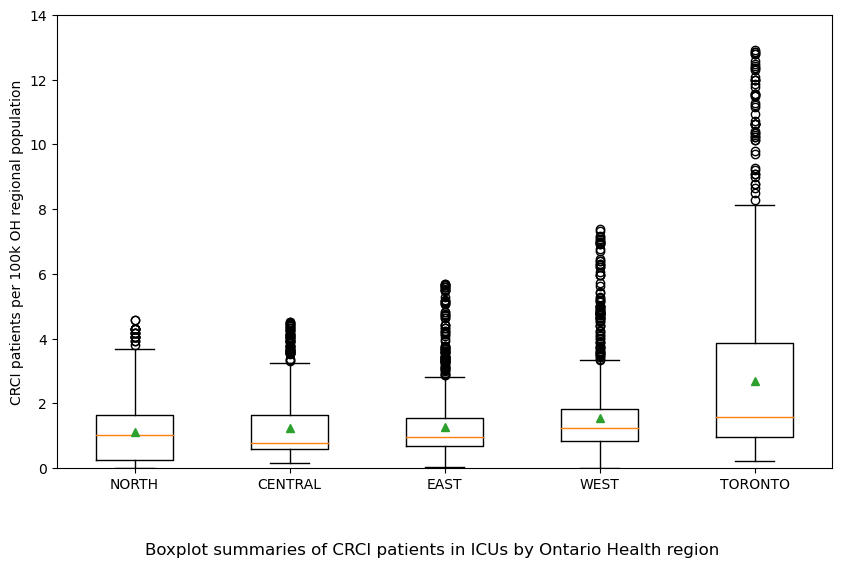

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot(df_region_icu.reset_index().set_index(['oh_region','date'])['icu_crci_total'].unstack().reindex(regions).values.tolist(),
          showmeans=True, labels=regions)
# df_region_icu.boxplot('icu_crci_total', by='oh_region', ax=ax, showmeans=True);
ax.set(ylabel='CRCI patients per 100k OH regional population', ylim=(0, 14))

fig.suptitle('Boxplot summaries of CRCI patients in ICUs by Ontario Health region', y=0)
fig.savefig('../output/crci_patients_by_oh_region_boxplots.png', bbox_inches='tight')